Statistics in Python
=====================

This workshop is adapted from a lesson by *Gaël Varoquaux* at [scipy-lectures.org](https://scipy-lectures.org/packages/statistics/)
   
### Why Python for statistics?
R is a language dedicated to statistics. Python is a general-purpose
    language with statistics modules. R has more statistical analysis
    features than Python. However, when it
    comes to building complex analysis pipelines that mix statistics with
    image analysis, text mining, or control of a physical
    experiment, the richness of Python is an invaluable asset.

In [18]:
# Libraries for handling arrays and dataframes
import numpy as np
import pandas as pd

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Library for hypothesis testing
from scipy import stats

# Library for regression modeling
import statsmodels as sm
from statsmodels.formula.api import ols

# Library for latex 
from IPython.display import Latex

Data representation and interaction
====================================

`brain_size.csv` is a CSV file, but the separator is ";"
 
Our data gives observations of brain size and weight and IQ (Willerman et al. 1991).


In [3]:
data = pd.read_csv('brain_size.csv', sep=';', na_values=".")
# data 


The weight of the second individual is missing in the CSV file. If we
   don't specify the missing value (NA = not available) marker, we will
   not be able to do statistical analysis.


*Side Note* 

**Creating from arrays**: We can also define a `pandas.DataFrame` from arrays. For example:


In [7]:
t = np.linspace(-6, 6, 20)
sin_t = np.sin(t)
cos_t = np.cos(t)

# We can make a pandas.DataFrame:
# pd.DataFrame({'t': t, 'sin': sin_t, 'cos': cos_t})  

**Other inputs**: [pandas](http://pandas.pydata.org) can input data from
SQL, excel files, or other formats. 

## Manipulating data

In [9]:
data.shape    # 40 rows and 8 columns
data.columns  # It has columns   
#print(data['Sex'])  # Columns can be addressed by name   
#print(data.Sex)  # or as an attribute   

# Simpler selector
data[data.Sex == 'Female'].mean()

Index(['Unnamed: 0', 'Sex', 'FSIQ', 'VIQ', 'PIQ', 'Weight', 'Height',
       'MRI_Count'],
      dtype='object')

**groupby**: splitting a dataframe on values of categorical variables:


In [23]:
groupby_sex = data.groupby('Sex')

`groupby_sex` is a powerful object that exposes many
operations on the resulting group of dataframes:

In [19]:
groupby_sex.mean()

,Unnamed: 0,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
Sex,,,,,,,
Female,19.65,111.9,109.45,110.45,137.200000,65.765000,862654.6
Male,21.35,115.0,115.25,111.60,166.444444,71.431579,954855.4


## Plotting data
**Scatter matrices**:

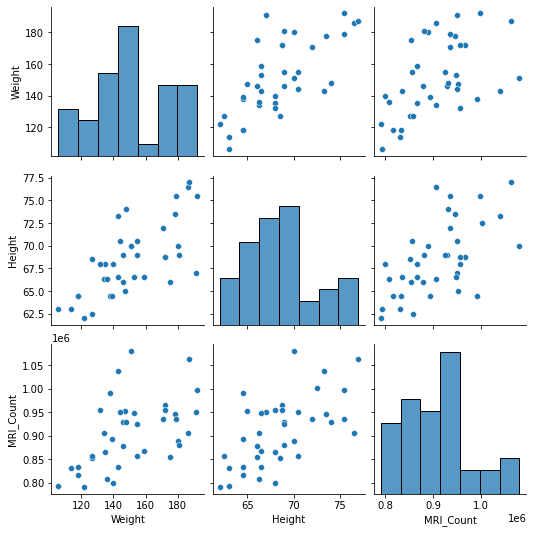

In [10]:
sns.pairplot(data[['Weight', 'Height', 'MRI_Count']])

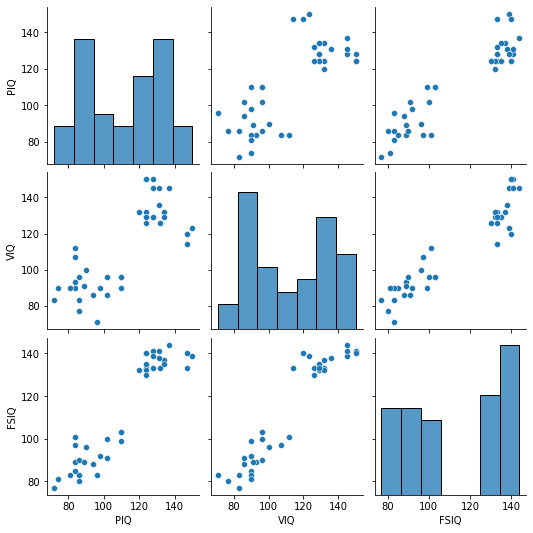

In [28]:
sns.pairplot(data[['PIQ', 'VIQ', 'FSIQ']])   

**Two populations**: The IQ metrics are bimodal, as if there are 2 sub-populations.


## Hypothesis testing: comparing two groups
For simple [statistical tests](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing), we will
use `scipy.stats` sub-module of [scipy](http://docs.scipy.org/doc/)

### 1-sample t-test: testing the value of a population mean
`scipy.stats.ttest_1samp` tests if the population mean of data is
likely to be equal to a given value (technically if observations are
drawn from a Gaussian distributions of given population mean). It returns
the [T statistic](https://en.wikipedia.org/wiki/Student%27s_t-test),
and the [p-value](https://en.wikipedia.org/wiki/P-value).


In [35]:
stats.ttest_1samp(data['VIQ'], 0)

Ttest_1sampResult(statistic=30.088099970849328, pvalue=1.3289196468728067e-28)

With a p-value of $10^{-28}$ we can claim that the population mean for
    the IQ (VIQ measure) is not 0.

### 2-sample t-test: testing for difference across populations
We have seen above that the mean VIQ in the male and female populations
were different. To test if this is significant, we do a 2-sample t-test
with `scipy.stats.ttest_ind`


In [36]:
female_viq = data[data['Sex'] == 'Female']['VIQ']
male_viq = data[data['Sex'] == 'Male']['VIQ']
stats.ttest_ind(female_viq, male_viq)

Ttest_indResult(statistic=-0.7726161723275011, pvalue=0.44452876778583217)

### Paired tests: repeated measurements on the same individuals
PIQ, VIQ, and FSIQ give 3 measures of IQ. Let us test if FISQ and PIQ are
significantly different. We can use a 2 sample test:


In [37]:
stats.ttest_ind(data['FSIQ'], data['PIQ'])

Ttest_indResult(statistic=0.465637596380964, pvalue=0.6427725009414841)

The problem with this approach is that it forgets that there are links
between observations: FSIQ and PIQ are measured on the same individuals.
Thus the variance due to inter-subject variability is confounding, and
can be removed, using a "paired test", or [repeated measures test](https://en.wikipedia.org/wiki/Repeated_measures_design)

In [38]:
stats.ttest_rel(data['FSIQ'], data['PIQ'])

Ttest_relResult(statistic=1.7842019405859857, pvalue=0.08217263818364236)

This is equivalent to a 1-sample test on the difference:


In [39]:
stats.ttest_1samp(data['FSIQ'] - data['PIQ'], 0)

Ttest_1sampResult(statistic=1.7842019405859857, pvalue=0.08217263818364236)

T-tests assume Gaussian errors. We can use a [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test), that relaxes
this assumption.


In [40]:
stats.wilcoxon(data['FSIQ'], data['PIQ'])

WilcoxonResult(statistic=274.5, pvalue=0.10659492713506856)

Note: The corresponding test in the non paired case is the [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U),
`scipy.stats.mannwhitneyu`.


**Conclusion**: we find that the data does not support the hypothesis
   that people of the male and female sex have different VIQ.

## Linear models, multiple factors, and analysis of variance
We saw how easy it is to fit a simple linear regression in `seaborn`.

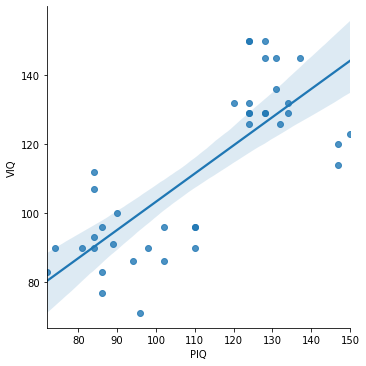

In [41]:
# A simple linear regression
sns.lmplot(x='PIQ', y='VIQ', data=data)


Given two set of observations, `x` and `y`, we want to test the
hypothesis that `y` is a linear function of `x`. In other terms:

$y = x * \beta + \alpha + \epsilon$ 

where $\epsilon$ is observation noise. 

We will use the [statsmodels](http://statsmodels.sourceforge.net/) module to:

- Fit a linear model. We will use the simplest strategy, [ordinary least
   squares](https://en.wikipedia.org/wiki/Ordinary_least_squares).

- Test that the coefficient $\beta$ is non zero.



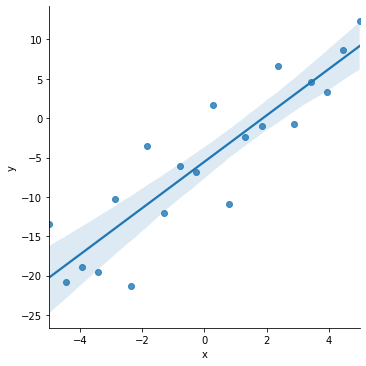

In [47]:
#First, we generate simulated data according to the model:
x = np.linspace(-5, 5, 20)
np.random.seed(1)

# normal distributed noise
y = -5 + 3*x + 4 * np.random.normal(size=x.shape)

# Create a data frame containing all the relevant variables
dataf = pd.DataFrame({'x': x, 'y': y})

sns.lmplot(data=dataf, x='x', y='y')

In [43]:
# Then we specify an OLS model and fit it:
model = ols("y ~ x", data).fit()

# We can inspect the various statistics derived from the fit::
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     74.03
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           8.56e-08
Time:                        22:17:22   Log-Likelihood:                -57.988
No. Observations:                  20   AIC:                             120.0
Df Residuals:                      18   BIC:                             122.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5335      1.036     -5.342      0.0

### Categorical variables: comparing groups or multiple categories
We can write a comparison between IQ of male and female using a linear
model:

                            OLS Regression Results                            
Dep. Variable:                    VIQ   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5969
Date:                Mon, 22 Feb 2021   Prob (F-statistic):              0.445
Time:                        22:21:17   Log-Likelihood:                -182.42
No. Observations:                  40   AIC:                             368.8
Df Residuals:                      38   BIC:                             372.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     109.4500      5.308     20.619      

<AxesSubplot:xlabel='Sex', ylabel='VIQ'>

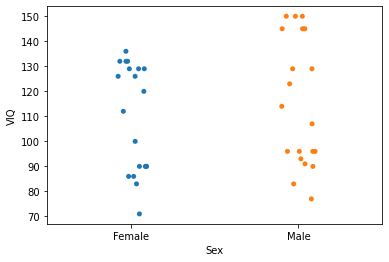

In [51]:
model = ols("VIQ ~ Sex + 1", data).fit()
print(model.summary())

sns.stripplot(x='Sex', y='VIQ',data=data)

**Tips on specifying model**
 
   **Forcing categorical**: the 'Sex' is automatically detected as a
   categorical variable, and thus each of its different values are
   treated as different entities.

   An integer column can be forced to be treated as categorical using:



In [56]:
model = ols('VIQ ~ C(Sex)', data).fit()
#print(model.summary())


**Intercept**: We can remove the intercept using `- 1` in the formula,
   or force the use of an intercept using `+ 1`.


*Tip:* By default, statsmodels treats a categorical variable with $K$ possible
     values as $K-1$ 'dummy' boolean variables (the last level being
     absorbed into the intercept term).  This is almost always a good
     default choice - however, it is possible to [specify different
     encodings for categorical variables](http://statsmodels.sourceforge.net/devel/contrasts.html).


### Multiple Regression: including multiple factors
Consider a linear model explaining a variable `z` (the dependent
variable) with 2 variables `x` and `y`:

$z = x * c_1 + y * c_2 + i + e$

Such a model can be seen in 3D as fitting a plane to a cloud of $(x,
y, z)$ points.


**Example: the iris data** (`iris.csv`)

.. tip:

    Sepal and petal size tend to be related: bigger flowers are bigger!
    But is there in addition a systematic effect of species?


In [1]:
iris = pd.read_csv('iris.csv')
iris.head()

sns.pairplot(iris, vars=['sepal_width','petal_length'], kind='reg', hue='name')
                 
model = ols('sepal_width ~ name + petal_length', data=iris).fit()
print(model.summary())  

NameError: name 'pd' is not defined

### Post-hoc hypothesis testing: analysis of variance (ANOVA)
In the above iris example, we wish to test if the petal length is
different between versicolor and virginica, after removing the effect of
sepal width. This can be formulated as testing the difference between the
coefficient associated to versicolor and virginica in the linear model
estimated above (it is an Analysis of Variance, [ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance). For this, we
write a **vector of 'contrast'** on the parameters estimated: we want to
test `name[T.versicolor] - name[T.virginica]`, with an [F-test](https://en.wikipedia.org/wiki/F-test):


In [16]:
print(model.f_test([0, 1, -1, 0]))
?model.f_test
#Is this difference significant?

<F test: F=array([[3.24533535]]), p=0.07369058781701113, df_denom=146, df_num=1>


**Key Points**

   * Hypothesis testing and p-values give you the **significance** of an
     effect / difference.

   * **Formulas** (with categorical variables) enable you to express rich
     links in your data.

   * **Visualizing** your data and fitting simple models give insight into the 
     data.

   * **Conditioning** (adding factors that can explain all or part of
     the variation) is an important modeling aspect that changes the
     interpretation.